# Identifying type of opinions in spanish wikipedia discussions 

In this analysis, we are going to automatically identify the kind of opinion of authors in the discussions on talk pages of spanish wikipedia.

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18

Load our labelled dataset, containing the opinions in the talk pages of wikipedia segmented by sentences assuming normal punctuation. This dataset includes the initial 1000 edits of talk pages of political leaders in America.

In [2]:
ds = pd.read_csv('data/wdds_v01.csv')
ds['creation_dt'] = pd.to_datetime(ds['timestamp'], unit='s')
ds.shape

(1204, 12)

remove unnecesary label 'discusión' in title

In [3]:
ds['page_title'] = ds.page_title.str.replace('Discusión:', '')

# exploratory analysis
Lets look the distribution of discussions per talk page

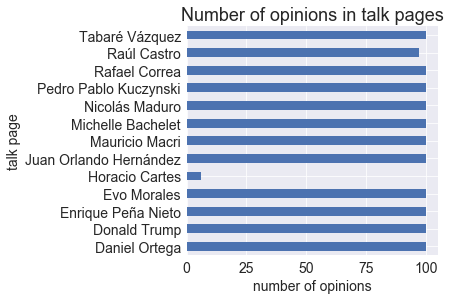

In [4]:
discussion_perpage= ds.groupby('page_title').size()
discussion_perpage.plot.barh()
plt.xlabel('number of opinions')
plt.ylabel('talk page')
plt.title('Number of opinions in talk pages')
plt.tight_layout()
plt.savefig('output/opiniontalkpagesdist.eps', format='eps')

In [5]:
sample=ds[~ds.topic.isnull()][['contributor','topic','opinion', 'type']].head()
sample.to_csv('output/sample.csv', index=False, sep='|')

almost all talk pages have same sample size, except one.  Now, lets look at the number of opinions by editor.

In [6]:
print(f'unique authors: {ds.contributor.nunique()}')

unique authors: 177


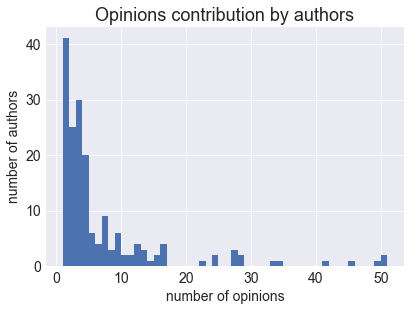

In [7]:
discussion_pereditor= ds.groupby('contributor').size()
discussion_pereditor= discussion_pereditor.sort_values(ascending=False)
discussion_pereditor.hist(bins=50)
plt.xlabel('number of opinions')
plt.ylabel('number of authors')
plt.title('Opinions contribution by authors')
plt.savefig('output/opauthorcontribdist.eps', format='eps')

Most authors have 10 or less opinions.  It could be useful to know if there are authors with opinions in multiple talk pages

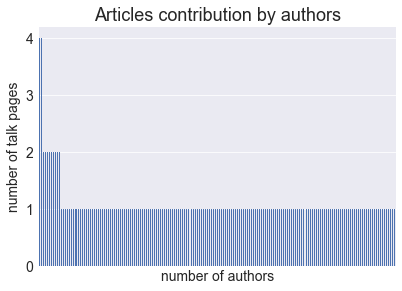

In [8]:
discussion_editor=ds.groupby(['contributor', 'page_title']).size().reset_index()
discussion_editor=discussion_editor['contributor'].value_counts()
discussion_editor=discussion_editor.reset_index() #.plot.area()
discussion_editor.plot.bar()
plt.legend([])
plt.xlabel('number of authors')
plt.xticks([])
plt.ylabel('number of talk pages')
plt.title('Articles contribution by authors')
plt.savefig('output/articlesauthorcontribdist.eps', format='eps')

Most authors only contribute to one discussions, with few authors contributing to two or more discussions.  Another aspect, it is the temporal distribution, lets look at it:

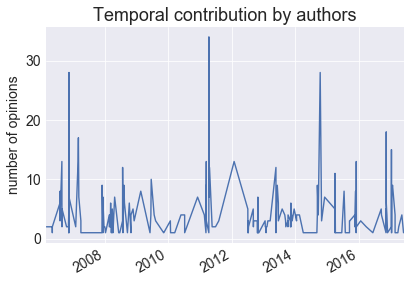

In [9]:
ts = ds.groupby(['creation_dt']).size()
ts.plot()
plt.xlabel('')
plt.ylabel('number of opinions')
plt.title('Temporal contribution by authors')
plt.savefig('output/temporalauthorcontribdist.eps', format='eps')

it seems there's some spikes at certain dates, probably related to real world events.  Now, let make the text analysis of the opinions.

# label analysis

annotation agreement

In [10]:
from sklearn.metrics import cohen_kappa_score

ds_r1 = pd.read_csv('data/wdds_v01_r1.csv')
ds_r2 = pd.read_csv('data/wdds_v01.csv')

ds_r = pd.merge(ds_r1, ds_r2, on=['row_id', 'page_id'])
ds_r['agreement'] = ds_r.type_x == ds_r.type_y
ds_r['agreement'] = ds_r['agreement'].apply(lambda x: float(x))
ds_rs = ds_r.groupby('type_x').agg({'agreement': 'mean'})
ds_rs = ds_rs.reset_index()
ds_rs.columns=['type', 'agreement']
ds_rs['kappa'] = cohen_kappa_score(ds_r.type_x, ds_r.type_y)
ds_rs.to_csv('output/agreement.csv', index=False)
ds_rs.head()

,type,agreement,kappa
0,ATT,1.0,1.0
1,ATT+,1.0,1.0
2,ATT-,1.0,1.0
3,ATTP,1.0,1.0
4,CL,1.0,1.0


let's look at the column that indicates the opinion type according to the taxonomy defined in the literature.

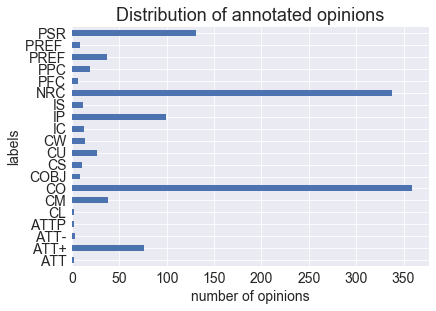

In [11]:
ds[['row_id','type']].groupby('type').count().plot.barh()
plt.xlabel('number of opinions')
plt.ylabel('labels')
plt.legend('')
plt.title('Distribution of annotated opinions')
plt.savefig('output/annotatedopinionsdist.eps', format='eps')

Now, we are going to analyze if there are different labels in each turn (the whole edit made by an author, generally a paragraph)

In [12]:
turns = ds.groupby(['page_id', 'contributor', 'creation_dt']).agg({'type':pd.Series.nunique})
turns = turns.reset_index()
turns = turns.groupby('type').count().reset_index()
#turns[['type','page_id']].plot.barh()
total = turns.page_id.sum()
turns['perc'] = turns.page_id/float(total)
turns = turns[['type', 'perc']]
turns.to_csv('output/labelsturnsdist.csv', index=False)
turns

,type,perc
0,1,0.421927
1,2,0.269103
2,3,0.176080
3,4,0.076412
4,5,0.036545
5,6,0.013289
6,7,0.006645


since the labels are unbalanced, in order to avoid problems in the classification task, we will select those types with more than 100 instances

In [13]:
labels = pd.read_csv('data/labels.csv')
labels_dict = labels['Label'].to_dict()
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
Label          33 non-null object
Category       33 non-null object
Name           33 non-null object
Description    23 non-null object
dtypes: object(4)
memory usage: 1.1+ KB


In [14]:
ds=ds[ds.type.isin(['PSR','NRC', 'CO', 'IP', 'ATT+'])]
ds[['row_id','type']].groupby('type').count()

,row_id
type,
ATT+,76
CO,359
IP,99
NRC,338
PSR,131


# text analysis

First, lets look characterize the opinions. First, let's analyze the length of the opinions and number of words

In [15]:
ds['oplen'] = ds.opinion.str.len()

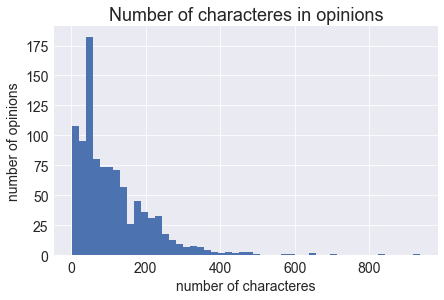

In [16]:
ds.oplen.hist(bins=50)
plt.xlabel('number of characteres')
plt.ylabel('number of opinions')
plt.title('Number of characteres in opinions')
plt.tight_layout()
plt.savefig('output/numcharsopdist.eps', format='eps')

as in most human activities, the length of opinions follow an power law distribution.  Now, let's look at the number of words:

In [17]:
from nltk.tokenize import word_tokenize

In [18]:
ds.opinion.fillna(value='', inplace=True)

In [19]:
ds['opnumwords'] = ds.opinion.apply(lambda s: len(word_tokenize(s, 'spanish')))

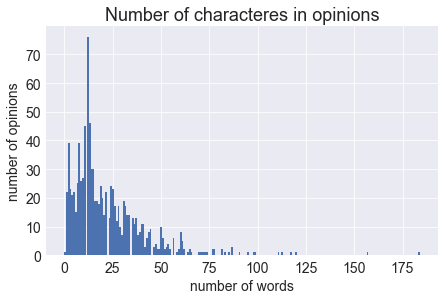

In [20]:
ds.opnumwords.hist(bins=200)
plt.xlabel('number of words')
plt.ylabel('number of opinions')
plt.title('Number of characteres in opinions')
plt.tight_layout()
plt.savefig('output/numwordsopdist.eps', format='eps')

as expected the distribution of length of words is very similar to characters in opinions. Although there are opinions with only one word, it may be useful to know what kind of opinions are those:

In [21]:
ds[ds.opnumwords<2].opinion.value_counts().head()

0          4
Err:508    2
etc..      2
|-         1
paz        1
Name: opinion, dtype: int64

some of them are meaningless others make sense such as: saludos, paz, gracias.  One of the challeges in the classification task will be to filter out meaningless words but filtering out useful words, specially when both have the similar frequencies.  Let's look at most used words with a word cloud excluding stop words.

In [22]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

use_stemmer = False
stemmer = SnowballStemmer("spanish")
stopset = set(stopwords.words('english') + stopwords.words('spanish'))

def tokenize(text):
    text = re.sub(r"(?:\#|@|https?\://)\S+", "", text)
    text = re.sub("[^a-zA-Z] ","",text)
    text = re.sub(r'\b\w{1,2}\b',' ',text)
    text = re.sub(r'http[\bs]*',' ',text)
    tokens = word_tokenize(text)
    if use_stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens

words = ' '.join(ds.opinion)

word_list = word_tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words with simple tokenization: {len(word_list)}')

use_stemmer=True
word_list = tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words with stemming removal: {len(word_list)}')

use_stemmer=False
word_list = tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words with stop words removal: {len(word_list)}')


wds = pd.DataFrame(word_list)
wds.columns = ['word']
wds=wds.word.value_counts().reset_index()
wds.columns=['word', 'count']
wds=wds[wds['count']>3]
print(f'number of words (TF min:3): {len(wds)}')


number of words with simple tokenization: 13461
number of words with stemming removal: 10687
number of words with stop words removal: 10000
number of words (TF min:3): 416


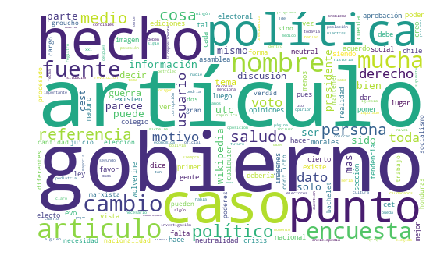

In [23]:
from wordcloud import WordCloud
filtered_words = ' '.join(wds.word)
wordcloud = WordCloud(background_color='white', width=500, height=300).generate(filtered_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
plt.savefig('output/wordcloud.eps', format='eps')

# classification task

For the classification task, let's analyze the labels distribution.

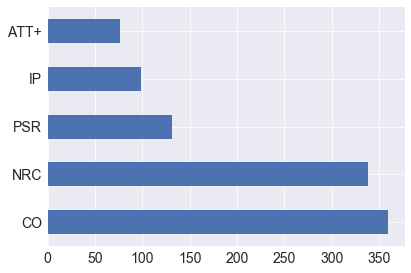

In [24]:
ds['target'] = ds['type']
ds['target'].value_counts().plot.barh()

as we can see, the labels are reasonable balanced, so we can apply the classification task based on type columns.  We will evaluate some dummy baselines, and two classification algorithms.

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    ds.opinion, ds.target, test_size=0.4, random_state=0)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

text_vectorizer = [
    ('vect', CountVectorizer(strip_accents='ascii', 
                             min_df=3, max_df=0.9,
                             stop_words=stopset, 
                             tokenizer=tokenize)),
    ('tfidf', TfidfTransformer(use_idf=True, sublinear_tf=True))
]

multinb_clf = Pipeline(text_vectorizer+[('clf', MultinomialNB())])
lsvc_clf = Pipeline(text_vectorizer+[('clf', LinearSVC())])
mf_clf = Pipeline(text_vectorizer+[('clf', DummyClassifier(strategy='most_frequent', random_state=0))])
uniform_clf = Pipeline(text_vectorizer+[('clf', DummyClassifier(strategy='uniform', random_state=0))])
strat_clf = Pipeline(text_vectorizer+[('clf', DummyClassifier(strategy='stratified', random_state=0))])
use_stemmer = True

## Evaluation of the performance on the test set

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

summary_scores = ['CI (95\%)', '']

uniform_clf.fit(X_train, y_train)
scores = cross_val_score(uniform_clf, X_train, y_train)
confidence_interval = scores.std() * 2
print("RND Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), confidence_interval))
summary_scores.extend([confidence_interval, '', ''])

parameters = {'clf__C':[0.1, 1, 10]}
parameters['clf__loss']=('hinge','squared_hinge')
parameters['clf__multi_class']= ('ovr', 'crammer_singer')
parameters['clf__class_weight'] = (None, 'balanced')
parameters['clf__tol'] = [1e-3, 1e-4]
lsvc_cv = GridSearchCV(lsvc_clf, parameters)
lsvc_cv.fit(X_train, y_train)
scores = cross_val_score(lsvc_cv, X_train, y_train)
confidence_interval = scores.std() * 2
print(f"LSVC best score: {lsvc_cv.best_score_}")
print(f"LSVC best params: {lsvc_cv.best_params_}")
print("LSVC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), confidence_interval))
summary_scores.extend([confidence_interval, '',''])

parameters = {'clf__alpha':[ 0.1, 1.0, 10.0]}
parameters['clf__fit_prior']= [True, False]
multinb_cv = GridSearchCV(multinb_clf, parameters)
multinb_cv.fit(X_train, y_train)
scores =  cross_val_score(multinb_cv, X_train, y_train)
confidence_interval = scores.std() * 2
print(f"MNB best score: {multinb_cv.best_score_}")
print(f"MNB best params: {multinb_cv.best_params_}")
print("MNB Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), confidence_interval))
summary_scores.extend([confidence_interval, '',''])



RND Accuracy: 0.19 (+/- 0.04)
LSVC best score: 0.5790349417637272
LSVC best params: {'clf__C': 1, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'clf__multi_class': 'ovr', 'clf__tol': 0.001}
LSVC Accuracy: 0.57 (+/- 0.03)
MNB best score: 0.5806988352745425
MNB best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
MNB Accuracy: 0.57 (+/- 0.01)


In [28]:
from sklearn.metrics import precision_recall_fscore_support

docs_test = X_test
labels = y_test.unique()
labels.sort()
rds = pd.DataFrame({'Label': labels})
macro_results = ['Macro', len(y_test)]

predicted = uniform_clf.predict(docs_test)
results = precision_recall_fscore_support(y_test, predicted)
macro_results.extend(precision_recall_fscore_support(y_test, predicted, average='macro')[:3])
rds['Support'] = results[3]
rds['BL-P'] = results[0]
rds['BL-R'] = results[1]
rds['BL-F1'] = results[2]

predicted = lsvc_cv.predict(docs_test)
results = precision_recall_fscore_support(y_test, predicted)
macro_results.extend(precision_recall_fscore_support(y_test, predicted, average='macro')[:3])
rds['LSVC-P'] = results[0]
rds['LSVC-R'] = results[1]
rds['LSVC-F1'] = results[2]

predicted = multinb_cv.predict(docs_test) 
results = precision_recall_fscore_support(y_test, predicted)
macro_results.extend(precision_recall_fscore_support(y_test, predicted, average='macro')[:3])
rds['MNB-P'] = results[0]
rds['MNB-R'] = results[1]
rds['MNB-F1'] = results[2]

rds.loc[len(rds)]=macro_results
rds.loc[len(rds)]=summary_scores

rds.to_csv('output/classif_report.csv', index=False)
rds

,Label,Support,BL-P,BL-R,BL-F1,LSVC-P,LSVC-R,LSVC-F1,MNB-P,MNB-R,MNB-F1
0,ATT+,26,0.123596,0.423077,0.191304,0.888889,0.615385,0.727273,0.928571,0.5,0.65
1,CO,153,0.394737,0.196078,0.262009,0.642857,0.705882,0.672897,0.583333,0.823529,0.682927
2,IP,26,0.117647,0.307692,0.170213,0.416667,0.384615,0.4,0.368421,0.269231,0.311111
3,NRC,148,0.406250,0.263514,0.319672,0.722973,0.722973,0.722973,0.762295,0.628378,0.688889
4,PSR,49,0.068493,0.102041,0.0819672,0.386364,0.346939,0.365591,0.451613,0.285714,0.35
5,Macro,402,0.222145,0.25848,0.205033,0.611550,0.555159,0.577747,0.618847,0.501371,0.536585
6,CI (95\%),,0.037086,,,0.028516,,,0.007632,,


In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[ 13,   3,   0,  10,   0],
       [  0, 126,   5,  10,  12],
       [  0,  15,   7,   2,   2],
       [  1,  46,   5,  93,   3],
       [  0,  26,   2,   7,  14]])

# model usage

In [30]:
sample = X_test[:2]
labels = y_test[:2]

docs_new = sample
predicted = lsvc_cv.predict(docs_new)

for doc, label, pred in zip(docs_new, labels, predicted):
    print('%r => %s, %s' % (doc, label, pred))


'estos detalles insensatos no ayudan al lectgor en lo más mínimo en comprender hernández, ni como persona ni como presidente de honduras.' => CO, CO
'aspectos asociados al 27f y su trabajo en onu mujeres, con mayor o menor desarrollo.' => NRC, CO
